Name: Samita Ghale

sn: 220257879

#  Activity classification

Implementing a machine learning workflow across a dataset that has been collected using as inertial sersor, visualize the dataset and test a set of machine learning algorithms to assess their performance for the task of activity classification.

### Content
- 1. Visualizations of the Datasets.
- 2. Feature Construction and visualizations for the feature sets.
- 3. Training and HyperParameter Optimizations.
- 4. Performance metrics/visualizations .
- 5. Conclusion

In [1]:
# Import Everything 
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import label_binarize
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree, export_text
from sklearn import model_selection


##  1. Visualizations of the Datasets.


### imu data information 
captured using a custom MPU-9259 IMU data logger
100 samples per second 
csv file 

    1."timestamp" 
    2."x-axis acceleration"  +/-8g
    3."z-axis aceleration"
    4."x-axis accelration" 
    5."x-axis gyro"         +/- 8000dps
    6."y-axis gyro"
    7."z-axis gyro"

In [2]:
# Set some lists to store the IMU data.
time_track = []
ax_set = []
ay_set = []
az_set = []
gx_set = []
gy_set = []
gz_set = []

activity_set = []

# map_activity(activity_string)
def map_activity(activity_string):
    if activity_string == 'Standing':
        return 0
    elif activity_string == 'Walking':
        return 1
    elif activity_string == 'Jogging':
        return 2
    elif activity_string == 'Side-Step':
        return 3
    elif activity_string == 'Running':
        return 4

In [3]:
# import the IMU data file
with open('a3_imu_data.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        time_track.append(float(row[0]));
        ax_set.append(float(row[1]));
        ay_set.append(float(row[2]));
        az_set.append(float(row[3]));
        gx_set.append(float(row[4]));
        gy_set.append(float(row[5]));
        gz_set.append(float(row[6]));

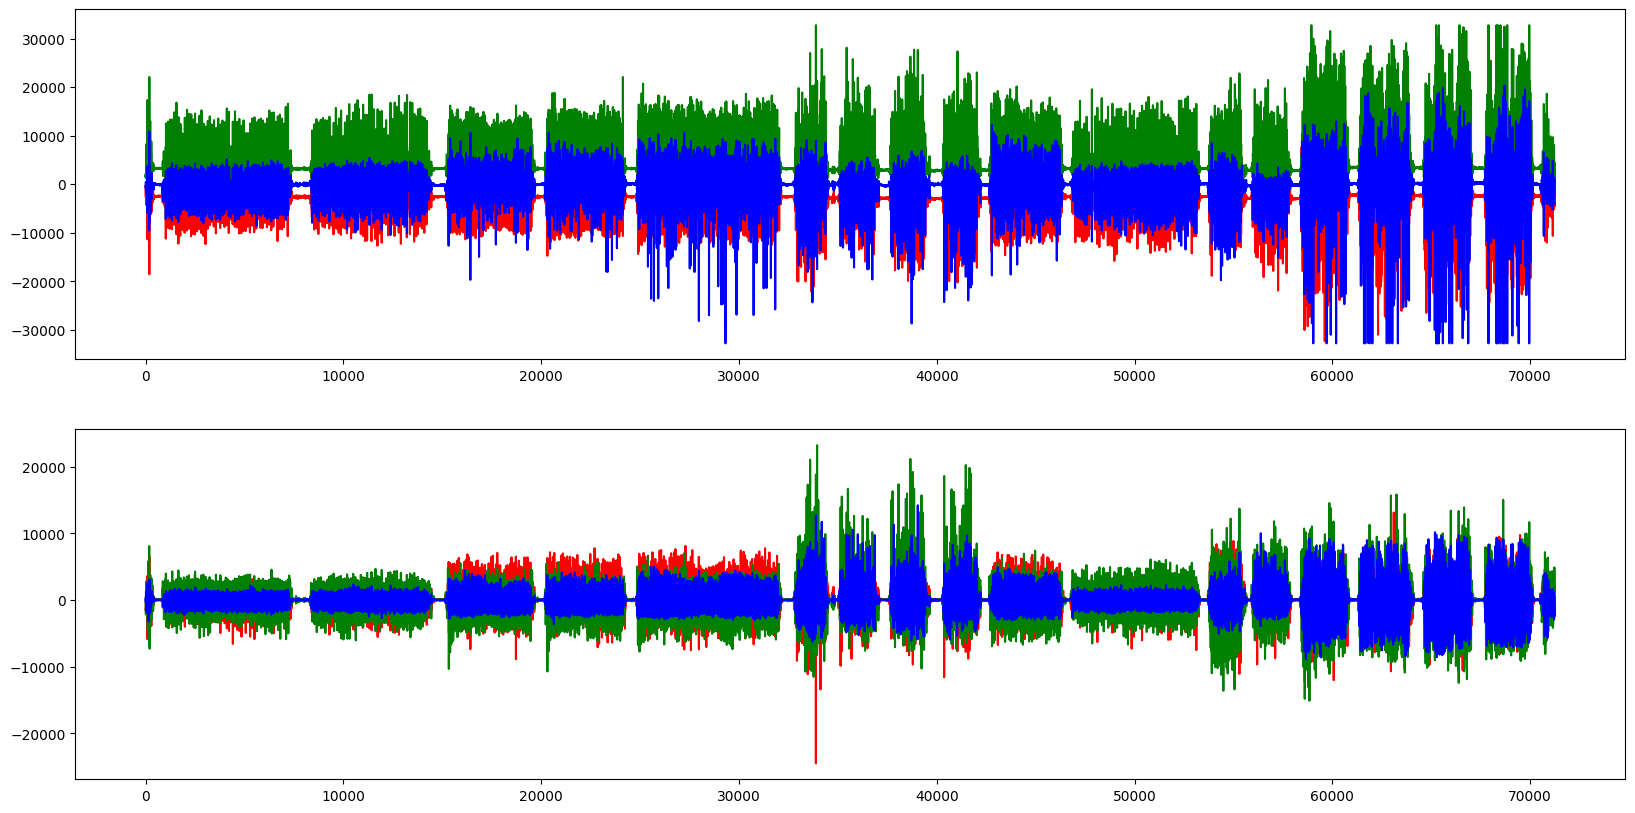

In [4]:
# visualise the data to sanity check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set, color='r')
axs[0].plot(ay_set, color='g')
axs[0].plot(az_set, color='b')

axs[1].plot(gx_set, color='r')
axs[1].plot(gy_set, color='g')
axs[1].plot(gz_set, color='b')

By inspection, we can see that the IMU data set is little off. The dataset should start with 1000 offest value to match the accompanying video. And at the end, extra walking value is added.By cutting out some extra piece we have the start and end of the video which matches the start and end of the activities and the IMU dataset.

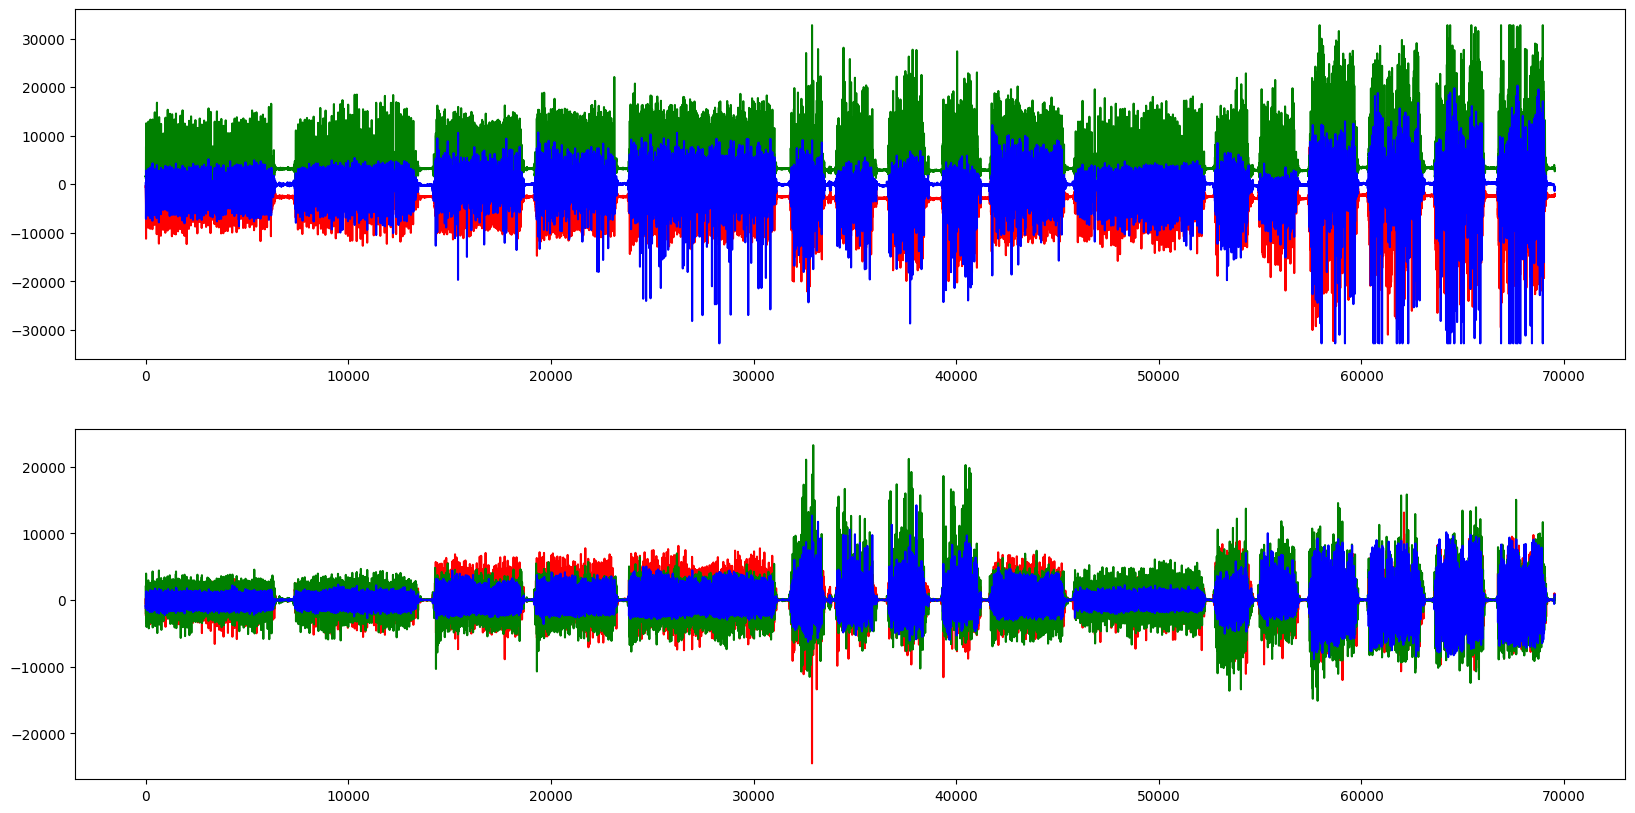

In [5]:
start_idx=1000
end_idx=-700
# visualise the data to sanity check
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(ax_set[start_idx:end_idx], color='r')
axs[0].plot(ay_set[start_idx:end_idx], color='g')
axs[0].plot(az_set[start_idx:end_idx], color='b')

axs[1].plot(gx_set[start_idx:end_idx], color='r')
axs[1].plot(gy_set[start_idx:end_idx], color='g')
axs[1].plot(gz_set[start_idx:end_idx], color='b')

The above fig shows the cut version of IMU dataset . 

 
### The Activity Annotations

Activity track that have been created using VoTT. 
CSV file contains rows corresponding to starting point of different activities that were undertaken using data capture session.
1. image
2. xmin
3. ymin 
4. xmax
5. ymax
6. label

In [6]:
with open('a3_activity_annotations.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader, None)  # skip the headers
    for row in reader:
        time_Stamp = (row[0].split('='))[1]
        activity_set.append([float(time_Stamp),row[-1], map_activity(row[-1])])

#### Question 
- Align and combine a dataset captured from an inertial sensor with an activity annotation file produced from a video recording of the data capture session.
- Visualize the combined dataset to check that the data has been correctly imported into Python and aligned with activity trasitions.
- Process the activity activity annotation data to assign a target activity to each data point with in the IMU dataset.

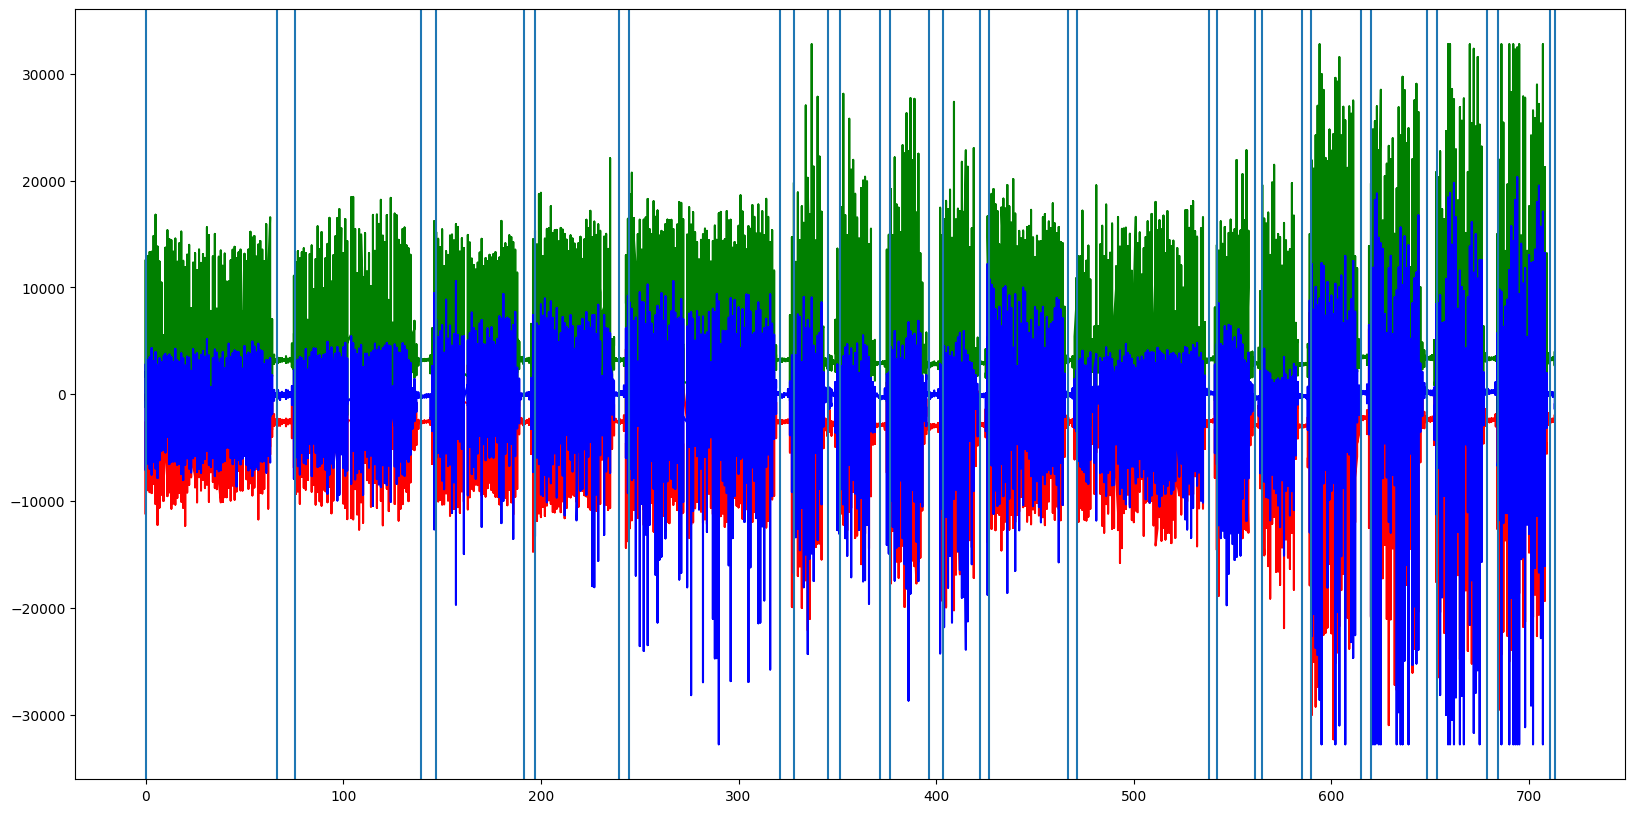

In [7]:
# activity time track for each data point within the imu timeseries.
activity_timeseries = [];
activity_string_timeseries = [];
activity_idx = 0;

# We need the time stamp for the start point
start_time = time_track[start_idx]

# The time track segment we are interested in 
time_track_segment = time_track[start_idx:end_idx]

#Add an 'end' activity - this book-ends the data
activity_set.append([time_track_segment[-1]-start_time, 'Standing'])

# Zero out the time track segment to make it match the video time
time_track_segment = np.array(time_track_segment)-start_time 

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(time_track_segment,ax_set[start_idx:end_idx], color='r')
ax.plot(time_track_segment,ay_set[start_idx:end_idx], color='g')
ax.plot(time_track_segment,az_set[start_idx:end_idx], color='b')


for imu_time_track_item in time_track_segment:
    current_time =  imu_time_track_item
    next_activity_ts = activity_set[activity_idx+1][0]
    
    # Here we need to move to the next activity in the annotations data if the current
    # IMU data point lies after the next annotation time stamp.
    if current_time > next_activity_ts:
        #Move to next activity
        activity_idx = activity_idx + 1;
        next_activity_ts = activity_set[activity_idx+1][0]
        
    activity_timeseries.append(activity_set[activity_idx][2])
    activity_string_timeseries.append(activity_set[activity_idx][1])
    
# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act))

The number of data points for each activity is shown with the help of a histogram diagram using the numeric activity code data.The following information will will inform the expected performance in a classifier algorithms below.

(array([ 9295., 19340., 19490., 11323., 10094.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

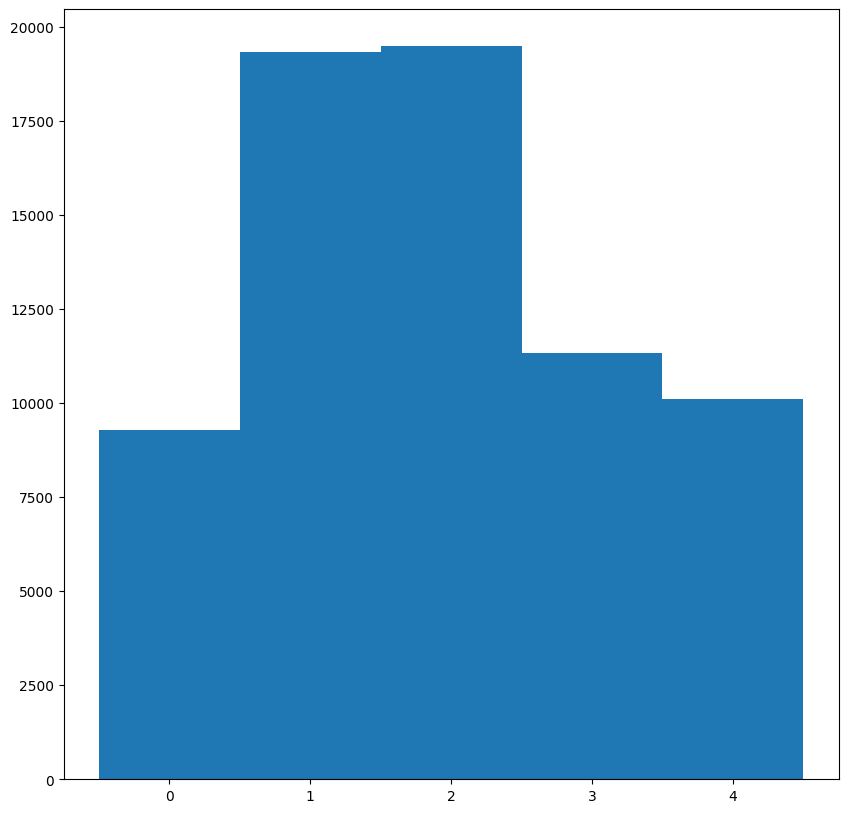

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(activity_timeseries,bins=[-0.5,0.5,1.5,2.5,3.5,4.5])

## 2. Feature Construction and visualizations for the feature sets.

For the Machine learning , we will only need the window value only which focuses on better performance and result in the model .

In [22]:
#We are only interested in the video window
ax_set = ax_set[start_idx:end_idx]
ay_set = ay_set[start_idx:end_idx]
az_set = az_set[start_idx:end_idx]
gx_set = gx_set[start_idx:end_idx]
gy_set = gy_set[start_idx:end_idx]
gz_set = gz_set[start_idx:end_idx]

### Machine Learning Features

we already combine the dataset, now we can apply machine learing workflow. 

we will compute features across the accelerometer and gyroscope datasets.
The features we will calculate are:
* Mean (x, y and z axes)
* Minimum (x, y and z axes)
* Maximum (x, y and z axes)
* The Signal Magnitude Area: $ SMA = \frac{1}{T} (\sum _{t=1}^{T} |{a_x(t)}| + \sum _{t=1}^{T} |{a_y(t)}| + (\sum _{t=1}^{T} |{a_z(t)}|)$

* Average intensity $ AI = \frac{1}{T} (\sum _{t=1}^{T} (\sqrt{a_x(t)^2 + a_y(t)^2 + a_y(t)^2})$

To make our data generalize , we are interesting in look at vedio window of data involve taking fixed-length segments of data and claculating features across these segments. 
We will use a **window size of 1 second**.

**question**
- calculate a set of features from the raw sensor data.


In [23]:
# machine learning workflow.
# initializing features and targets window
feature_set = []
target_set  = []            
window_size = 1.0;            

for t in range(int(time_track_segment[0]),int(time_track_segment[-1])):
    
    #There is a missing data-point (probably due to a bad segment on the SD card)
    if  t== 103 or t == 102 or t== 161 or t == 162 or t== 272 or t == 273 :
        continue
    #The index function finds the index of the first occurnace of the data
    window_start_idx = list(time_track_segment).index(t)
    window_end_idx = list(time_track_segment).index(t+window_size)
    
    ax_window = ax_set[window_start_idx:window_end_idx]
    ay_window = ay_set[window_start_idx:window_end_idx]
    az_window = az_set[window_start_idx:window_end_idx]
    gx_window = gx_set[window_start_idx:window_end_idx]
    gy_window = gy_set[window_start_idx:window_end_idx]
    gz_window = gz_set[window_start_idx:window_end_idx]

    #activity that will be assigned to the set of features
    activity_code = activity_timeseries[window_start_idx]

    # Now we can build features from the data window
    # Mean
    mu_ax = statistics.mean(ax_window)
    mu_ay = statistics.mean(ay_window)
    mu_az = statistics.mean(az_window)
    mu_gx = statistics.mean(gx_window)
    mu_gy = statistics.mean(gy_window)
    mu_gz = statistics.mean(gz_window)
    
    # Max
    max_ax = max(ax_window)
    max_ay = max(ay_window)
    max_az = max(az_window)
    max_gx = max(gx_window)
    max_gy = max(gy_window)
    max_gz = max(gz_window)
    
    # Min
    min_ax = min(ax_window)
    min_ay = min(ay_window)
    min_az = min(az_window)
    min_gx = min(gx_window)
    min_gy = min(gy_window)
    min_gz = min(gz_window)
    
    ax_abs_sum = 0
    ay_abs_sum = 0
    az_abs_sum = 0
    
    gx_abs_sum = 0
    gy_abs_sum = 0
    gz_abs_sum = 0
    
    a_sum_sq = 0
    g_sum_sq = 0
    
    # Here we need to accumulate the values to calculate the SMA and AI
    for i in range(0, len(ax_window)):
        
        # Add up the absolute values for the SMA
        ax_abs_sum = ax_abs_sum + abs(ax_window[i])
        ay_abs_sum = ay_abs_sum + abs(ay_window[i])
        az_abs_sum = az_abs_sum + abs(az_window[i])
        
        gx_abs_sum = gx_abs_sum + abs(gx_window[i])
        gy_abs_sum = gy_abs_sum + abs(gy_window[i])
        gz_abs_sum = gz_abs_sum + abs(gz_window[i])
        
        
        a_sum_sq = ((ax_window[i]**2) + (ay_window[i]**2) + (az_window[i]**2)) + a_sum_sq
        g_sum_sq = ((gx_window[i]**2) + (gy_window[i]**2) + (gz_window[i]**2)) + g_sum_sq

    # Signal Magnitude area    
    a_sma = (ax_abs_sum + ay_abs_sum + az_abs_sum) / len(ax_window)
    g_sma = (gx_abs_sum + gy_abs_sum + gz_abs_sum) / len(ax_window)

    # Average intensity
    a_av_intensity = math.sqrt(a_sum_sq) / len(ax_window)
    g_av_intensity = math.sqrt(g_sum_sq) / len(ax_window)


    feature_row = [mu_ax, mu_ay, mu_az, mu_gx, mu_gy, mu_gz, \
                   max_ax, max_ay, max_az, max_gx, max_gy, max_gz, \
                   min_ax, min_ay, min_az, min_gx, min_gy, min_gz, \
                   a_sma, g_sma, a_av_intensity, g_av_intensity]

    feature_set.append(feature_row)
    target_set.append(activity_code)


StatisticsError: mean requires at least one data point

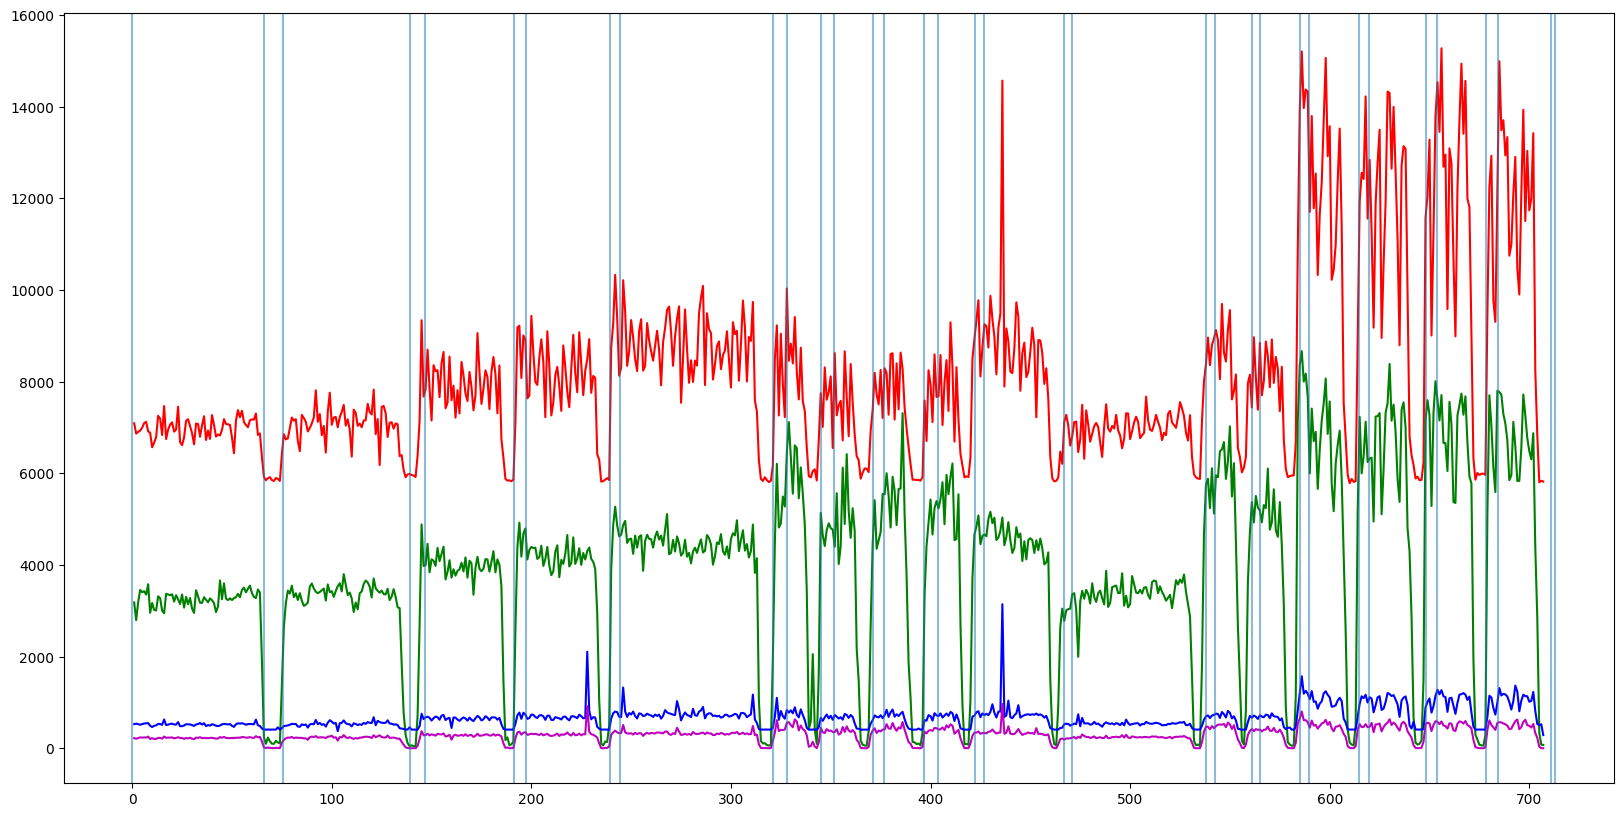

In [11]:
# visualise some of the features i.e. AI and SMA
fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(range(1,708),np.array(feature_set)[:,:6], color='k')
# ax.plot(range(1,708),np.array(feature_set)[:,6:12], color='y')
# ax.plot(range(1,708),np.array(feature_set)[:,12:18], color='c')
ax.plot(range(1,708),np.array(feature_set)[:,18], color='r')
ax.plot(range(1,708),np.array(feature_set)[:,19], color='g')
ax.plot(range(1,708),np.array(feature_set)[:,20], color='b')
ax.plot(range(1,708),np.array(feature_set)[:,21], color='m')

# Plot the location of the activity transitions just to sanity check the data
for act in np.array(list(zip(*activity_set)))[0,:]:
    ax.axvline(float(act), alpha=0.5)


## 3. Training and HyperParameter Optimizations.
 for each algorithms >>>

## 4. Performance metrics/visualizations .
for each algorithm >>>

### Applying a Machine Learning Classifier

**Questions**
- Apply a machine learning workflow to test a selection of classification algorithms on the activity classification.
- Perform hyper-parameter optimization on at least one parameter for each algorithm.

#### machine learning workflow
+ Decision Tree *
+ K-Nearest Neighbors *
- Random Forest *
- AdaBoost
- Support Vector Machine/Stochastic Gradient Descendent Classifier 

we are constructing a workflow for
- Decision Tree classifier
- K-Nearest Neighbors
- Random Forest

## Decision Tree Classifier

for this classification algorithm we have choosen a
 **max_depth** as as hyper-parameter 

In [12]:
# splitting the data set into train and test datasets 
# using train_test_split function from sklearn

X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
 
# optimizing the hyper parameter  max-depth
# we start the hyper parameter from 1 to 21 and chooose the best one which gives maximum score 
for max_d in range(1, 21):
    clf = DecisionTreeClassifier(max_depth=max_d)
    clf.fit(X_train, y_train)
    print('The Training Accuracy for max_depth {} is:'.format(max_d), clf.score(X_train, y_train))
    print('The Test Accuracy for max_depth {} is:'.format(max_d), clf.score(X_test,y_test))
    print('')


The Training Accuracy for max_depth 1 is: 0.539622641509434
The Test Accuracy for max_depth 1 is: 0.519774011299435

The Training Accuracy for max_depth 2 is: 0.7377358490566037
The Test Accuracy for max_depth 2 is: 0.7005649717514124

The Training Accuracy for max_depth 3 is: 0.8679245283018868
The Test Accuracy for max_depth 3 is: 0.8418079096045198

The Training Accuracy for max_depth 4 is: 0.8981132075471698
The Test Accuracy for max_depth 4 is: 0.8305084745762712

The Training Accuracy for max_depth 5 is: 0.9283018867924528
The Test Accuracy for max_depth 5 is: 0.8361581920903954

The Training Accuracy for max_depth 6 is: 0.9566037735849057
The Test Accuracy for max_depth 6 is: 0.7966101694915254

The Training Accuracy for max_depth 7 is: 0.9792452830188679
The Test Accuracy for max_depth 7 is: 0.8192090395480226

The Training Accuracy for max_depth 8 is: 0.9924528301886792
The Test Accuracy for max_depth 8 is: 0.8135593220338984

The Training Accuracy for max_depth 9 is: 0.998113

After Optimization on **max_depth**  we have found that the optimal value is 10 or 20 .

CV Train Recall: [0.44117647 0.92307692 0.89361702 0.70454545 0.83116883]
CV Train Precision: [0.50847458 0.9        0.8630137  0.72093023 0.81012658]
CV Train F1 Score: [0.47244094 0.91139241 0.87804878 0.71264368 0.82051282]
Test Recall: [0.52       0.775      0.87931034 0.88461538 0.85714286]
Test Precision: [0.46428571 0.88571429 0.91071429 0.82142857 0.8       ]
Test F1 Score: [0.49056604 0.82666667 0.89473684 0.85185185 0.82758621]


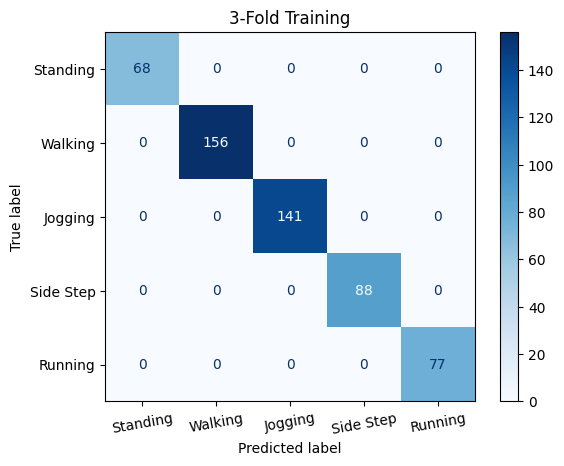

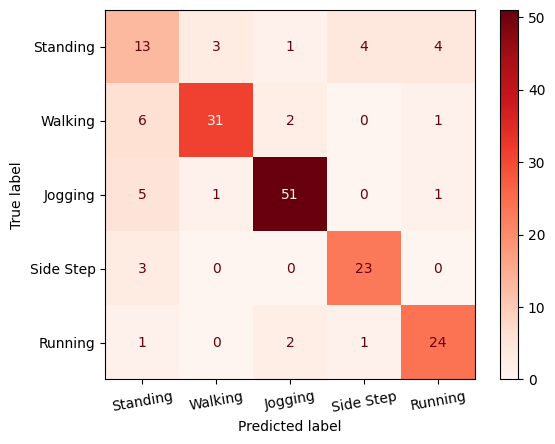

In [13]:
# Train with Decision tree classifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# Print out the recall, precision and F1 scores
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
# for train data
fig, ax = plt.subplots()
ax.set_title('3-Fold Training')
disp = ConfusionMatrixDisplay.from_estimator(clf ,X_train, y_train,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(10)

#  for test data
fig, ax = plt.subplots()    
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Reds,ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(10)

**Performance of the Decision tree**
The above output data shows the Train Recall , Train precision, Train F1-score, Test Recall , Test Precision and Test F1-score value
The above two confusion matrix show the detail about Train data confusion matrix and test confusion matrix

[Text(0.47684151785714285, 0.9444444444444444, 'max_gx <= 3063.5\ngini = 0.777\nsamples = 530\nvalue = [68, 156, 141, 88, 77]'),
 Text(0.19029017857142858, 0.8333333333333334, 'min_az <= -3954.0\ngini = 0.53\nsamples = 240\nvalue = [51, 155, 10, 17, 7]'),
 Text(0.05357142857142857, 0.7222222222222222, 'max_gz <= 2320.0\ngini = 0.065\nsamples = 150\nvalue = [1, 145, 1, 3, 0]'),
 Text(0.03571428571428571, 0.6111111111111112, 'g_av_intensity <= 195.158\ngini = 0.027\nsamples = 147\nvalue = [1, 145, 1, 0, 0]'),
 Text(0.017857142857142856, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0, 0]'),
 Text(0.05357142857142857, 0.5, 'g_sma <= 3987.007\ngini = 0.014\nsamples = 146\nvalue = [0, 145, 1, 0, 0]'),
 Text(0.03571428571428571, 0.3888888888888889, 'gini = 0.0\nsamples = 145\nvalue = [0, 145, 0, 0, 0]'),
 Text(0.07142857142857142, 0.3888888888888889, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0, 0]'),
 Text(0.07142857142857142, 0.6111111111111112, 'gini = 0.0\nsamples = 3\nvalue = [0, 0,

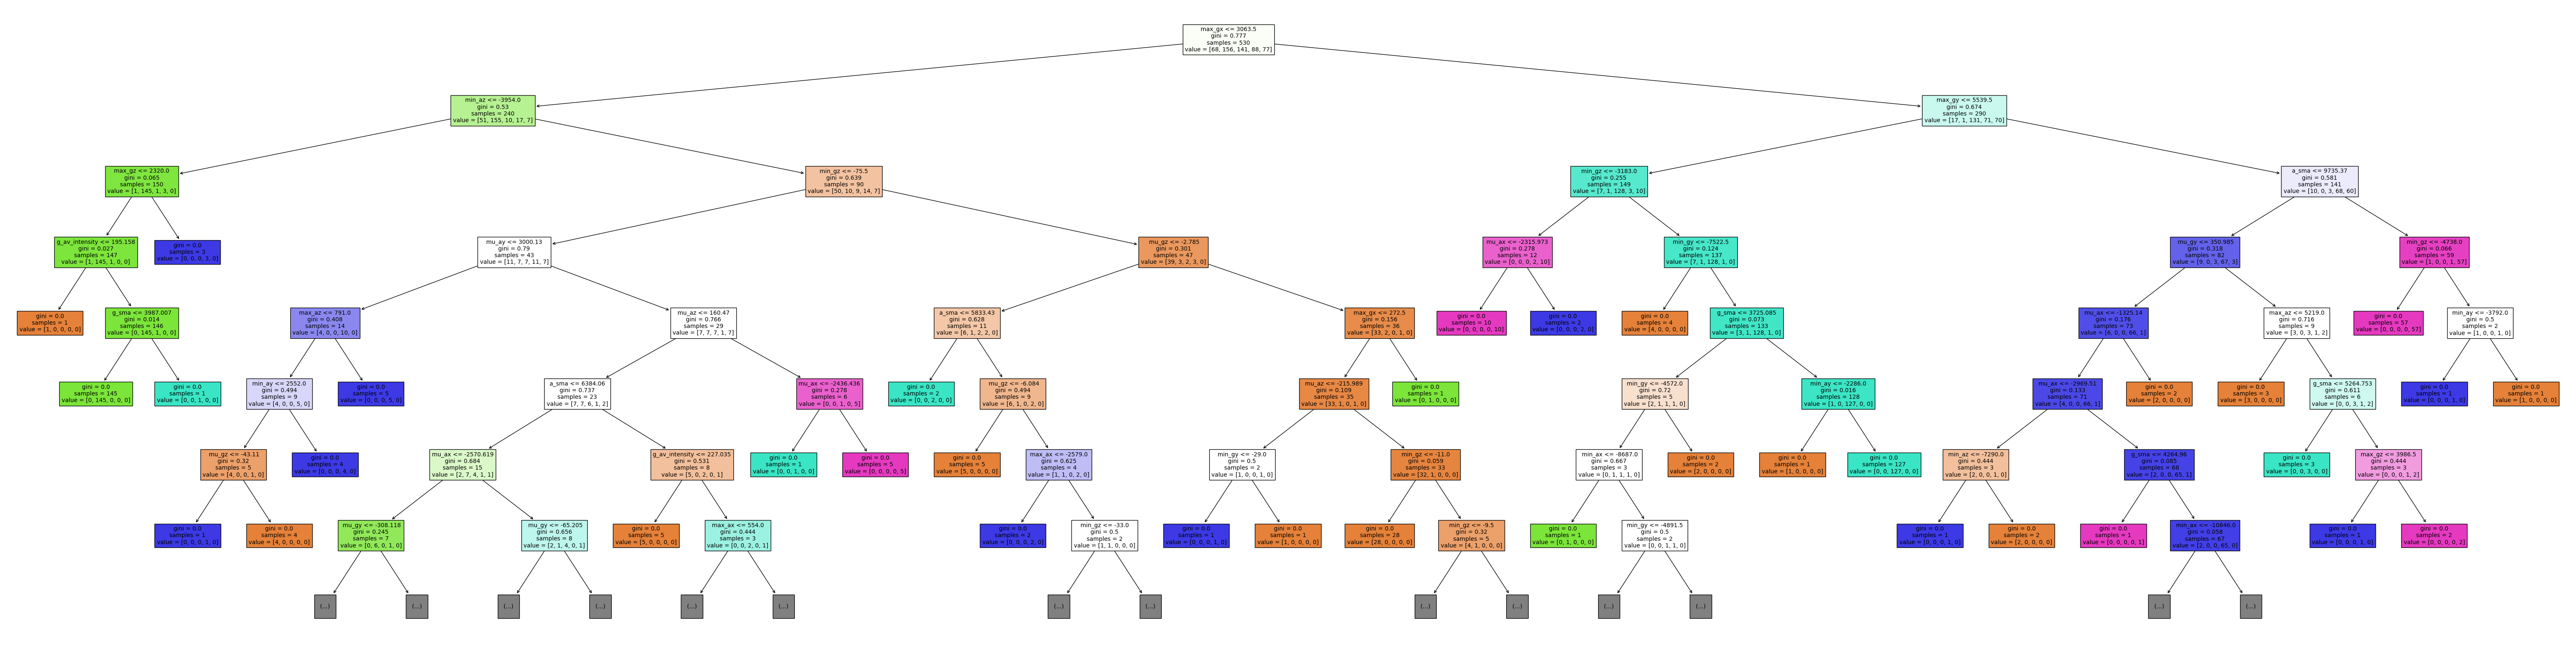

In [14]:
# visualizing the best classifier using plot_tree function.
plt.figure(figsize=(80, 20))
plot_tree(clf, feature_names=["mu_ax", "mu_ay", "mu_az", "mu_gx"," mu_gy"," mu_gz", \
                   "max_ax", "max_ay","max_az", "max_gx", "max_gy", "max_gz", \
                  " min_ax", "min_ay", "min_az", "min_gx", "min_gy", "min_gz", \
                   "a_sma", "g_sma", "a_av_intensity", "g_av_intensity"], max_depth=7,filled= True)

##  K-Nearest Neighbors

for this classification algorithm we have choosen a **n_neighbours** as as hyper-parameter 

In [15]:
# optimization process for n_neighbours hyperparameter
for n in range(1, 21):
    clf = neighbors.KNeighborsClassifier(n, weights='uniform')
    clf.fit(X_train, y_train)
    print('The Training Accuracy for max_depth {} is:'.format(n), clf.score(X_train, y_train))
    print('The Test Accuracy for max_depth {} is:'.format(n), clf.score(X_test,y_test))
    print('')

The Training Accuracy for max_depth 1 is: 1.0
The Test Accuracy for max_depth 1 is: 0.8531073446327684

The Training Accuracy for max_depth 2 is: 0.9226415094339623
The Test Accuracy for max_depth 2 is: 0.8361581920903954

The Training Accuracy for max_depth 3 is: 0.9169811320754717
The Test Accuracy for max_depth 3 is: 0.847457627118644

The Training Accuracy for max_depth 4 is: 0.9150943396226415
The Test Accuracy for max_depth 4 is: 0.8531073446327684

The Training Accuracy for max_depth 5 is: 0.9056603773584906
The Test Accuracy for max_depth 5 is: 0.864406779661017

The Training Accuracy for max_depth 6 is: 0.8962264150943396
The Test Accuracy for max_depth 6 is: 0.8700564971751412

The Training Accuracy for max_depth 7 is: 0.8905660377358491
The Test Accuracy for max_depth 7 is: 0.864406779661017

The Training Accuracy for max_depth 8 is: 0.8849056603773585
The Test Accuracy for max_depth 8 is: 0.8757062146892656

The Training Accuracy for max_depth 9 is: 0.8773584905660378
The T

CV Train Recall: [0.69565217 0.94701987 0.93918919 0.81707317 0.8       ]
CV Train Precision: [0.67605634 0.85119048 0.95205479 0.84810127 0.96969697]
CV Train F1 Score: [0.68571429 0.89655172 0.94557823 0.83229814 0.87671233]
Test Recall: [0.70833333 0.97777778 0.90196078 0.8125     0.72      ]
Test Precision: [0.65384615 0.88       0.86792453 0.86666667 1.        ]
Test F1 Score: [0.68       0.92631579 0.88461538 0.83870968 0.8372093 ]


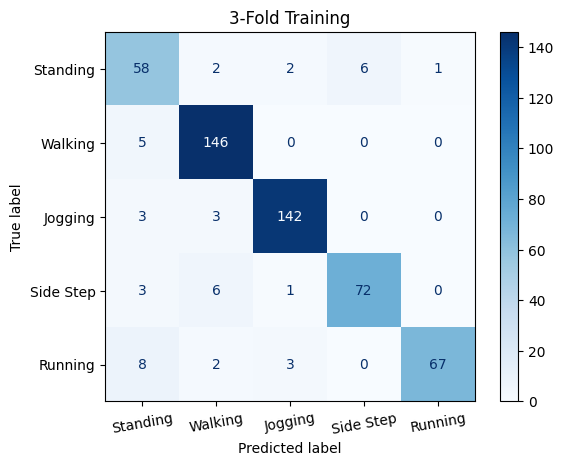

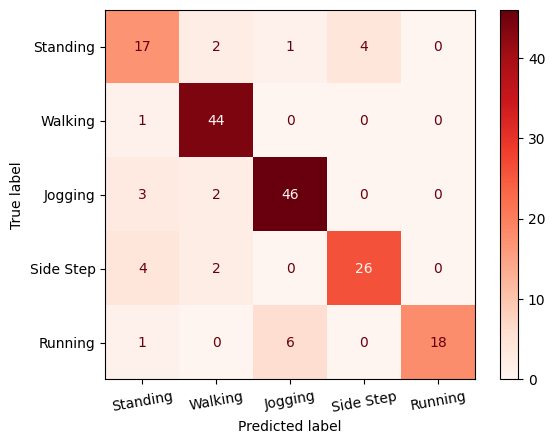

In [16]:
#-Nearest Neighbors classifier.
# spliting the dataset as above
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
# Set the number neighbours to use in the classifier
# one of the hyper parameter
n_neighbors = 3
# Train
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X_train, y_train)

# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)


# Print out the recall, precision and F1 scores
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
# for train data
fig, ax = plt.subplots()
ax.set_title('3-Fold Training')
disp = ConfusionMatrixDisplay.from_estimator(clf ,X_train, y_train,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(10)

#  for test data
fig, ax = plt.subplots()    
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Reds,ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(10)

Above confusion matrix show the 3-fold crossvalidation . 
The percision , F1-score and recall is printed out above to determine and tweak the hyperparameter

## Random Forest Classifier

In [17]:
# To compare results, we create a base model without
# any hyperparameters. 
clf = RandomForestClassifier(random_state = 24, n_jobs = -1)
clf.fit(X_train, y_train)
base_model = clf
base_train_acc = base_model.score(X_train , y_train)
base_test_acc = base_model.score(X_test, y_test)
print(base_train_acc, base_test_acc)

1.0 0.8700564971751412


we are choosing hyper-parameter **n_estimators** 

In [18]:
# n_estimators  as a hyper-parameter
for n_es in range(70, 100, 2):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=n_es)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train , y_train)
    test_acc = model.score(X_test, y_test)
    print(n_es,train_acc, test_acc)

70 1.0 0.8926553672316384
72 1.0 0.8926553672316384
74 1.0 0.8926553672316384
76 1.0 0.8926553672316384
78 1.0 0.8870056497175142
80 1.0 0.8926553672316384
82 1.0 0.8926553672316384
84 1.0 0.8926553672316384
86 1.0 0.8870056497175142
88 1.0 0.8870056497175142
90 1.0 0.8870056497175142
92 1.0 0.8813559322033898
94 1.0 0.8813559322033898
96 1.0 0.8813559322033898
98 1.0 0.8813559322033898


we came into conlusion that the hyper parameter n_estimators best value is 90

CV Train Recall: [0.55882353 0.91780822 0.93243243 0.86956522 0.81578947]
CV Train Precision: [0.55882353 0.90540541 0.90789474 0.82474227 0.95384615]
CV Train F1 Score: [0.55882353 0.91156463 0.92       0.84656085 0.87943262]
Test Recall: [0.76       1.         0.96078431 0.86363636 0.89655172]
Test Precision: [0.82608696 0.96153846 0.94230769 0.79166667 1.        ]
Test F1 Score: [0.79166667 0.98039216 0.95145631 0.82608696 0.94545455]


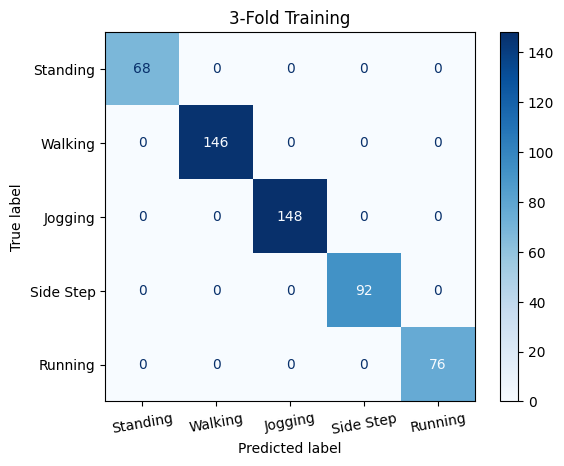

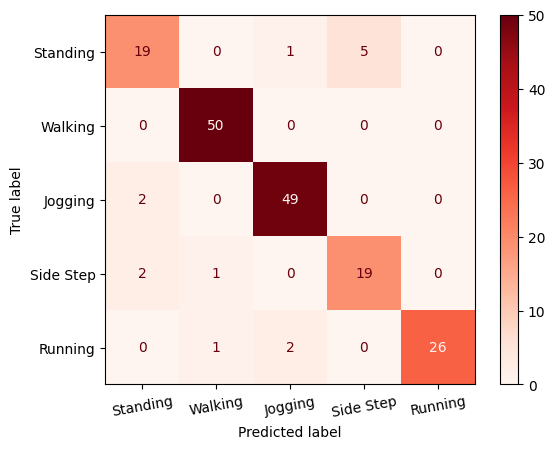

In [19]:
# Now we can apply a classifier -
# spliting the data set into train and test data 
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set)
# Set the number neighbours to use in the classifier
n_estimators = 90 #from the optimization
# Train
# we create an instance of Neighbours Classifier and fit the data.
clf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=n_es)
clf.fit(X_train, y_train)

# Return the predictions for the 3-Fold crossvalidation
y_predicted = cross_val_predict(clf, X_train,y_train, cv=3)
# Return the predictions for the test set
y_test_predicted = clf.predict(X_test)
# Construct the confusion matricies
conf_mat_train = confusion_matrix(y_train, y_predicted)
conf_mat_test = confusion_matrix(y_test, y_test_predicted)


# Print out the recall, precision and F1 scores
# There will be a value for each class
# CV Train
print("CV Train Recall:", recall_score(y_train,y_predicted,average=None))
print("CV Train Precision:",precision_score(y_train,y_predicted,average=None))
print("CV Train F1 Score:",f1_score(y_train,y_predicted,average=None))

# Test
print("Test Recall:",recall_score(y_test,y_test_predicted,average=None))
print("Test Precision:",precision_score(y_test,y_test_predicted,average=None))
print("Test F1 Score:",f1_score(y_test,y_test_predicted,average=None))

# Plot the confusion matrices using the pretty functions
# for train data
fig, ax = plt.subplots()
ax.set_title('3-Fold Training')
disp = ConfusionMatrixDisplay.from_estimator(clf ,X_train, y_train,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Blues,ax=ax)
# Rotate the labels so they can be read
for tick in ax.get_xticklabels():
    tick.set_rotation(10)

#  for test data
fig, ax = plt.subplots()    
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
            display_labels=['Standing', 'Walking','Jogging', 'Side Step','Running'],
            cmap=plt.cm.Reds,ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(10)

The above confusion matrix visualize the percision, recall and f1-score value of the model .

## Comparing above algorithm

KNN: 0.867925 (0.035799)
DTC: 0.805660 (0.056635)
RFC: 0.871698 (0.040291)


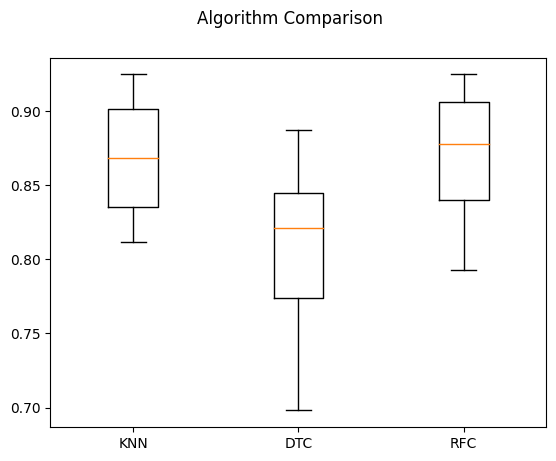

In [20]:
# prepare models
models = []
models.append(('KNN', neighbors.KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
seed = 42
scoring = 'accuracy'
for name, model in models:
#     this model_selection function is easy to use and simple for model selection
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

From the above workflow , we came to conclusion that **Random Forest Classification** is best among these above algorithms. The plot show that the value is 87% accurate for the Random forest where as  for 
k-nearest = 86%
    which is also not bad at all and
Decision tree = 80%


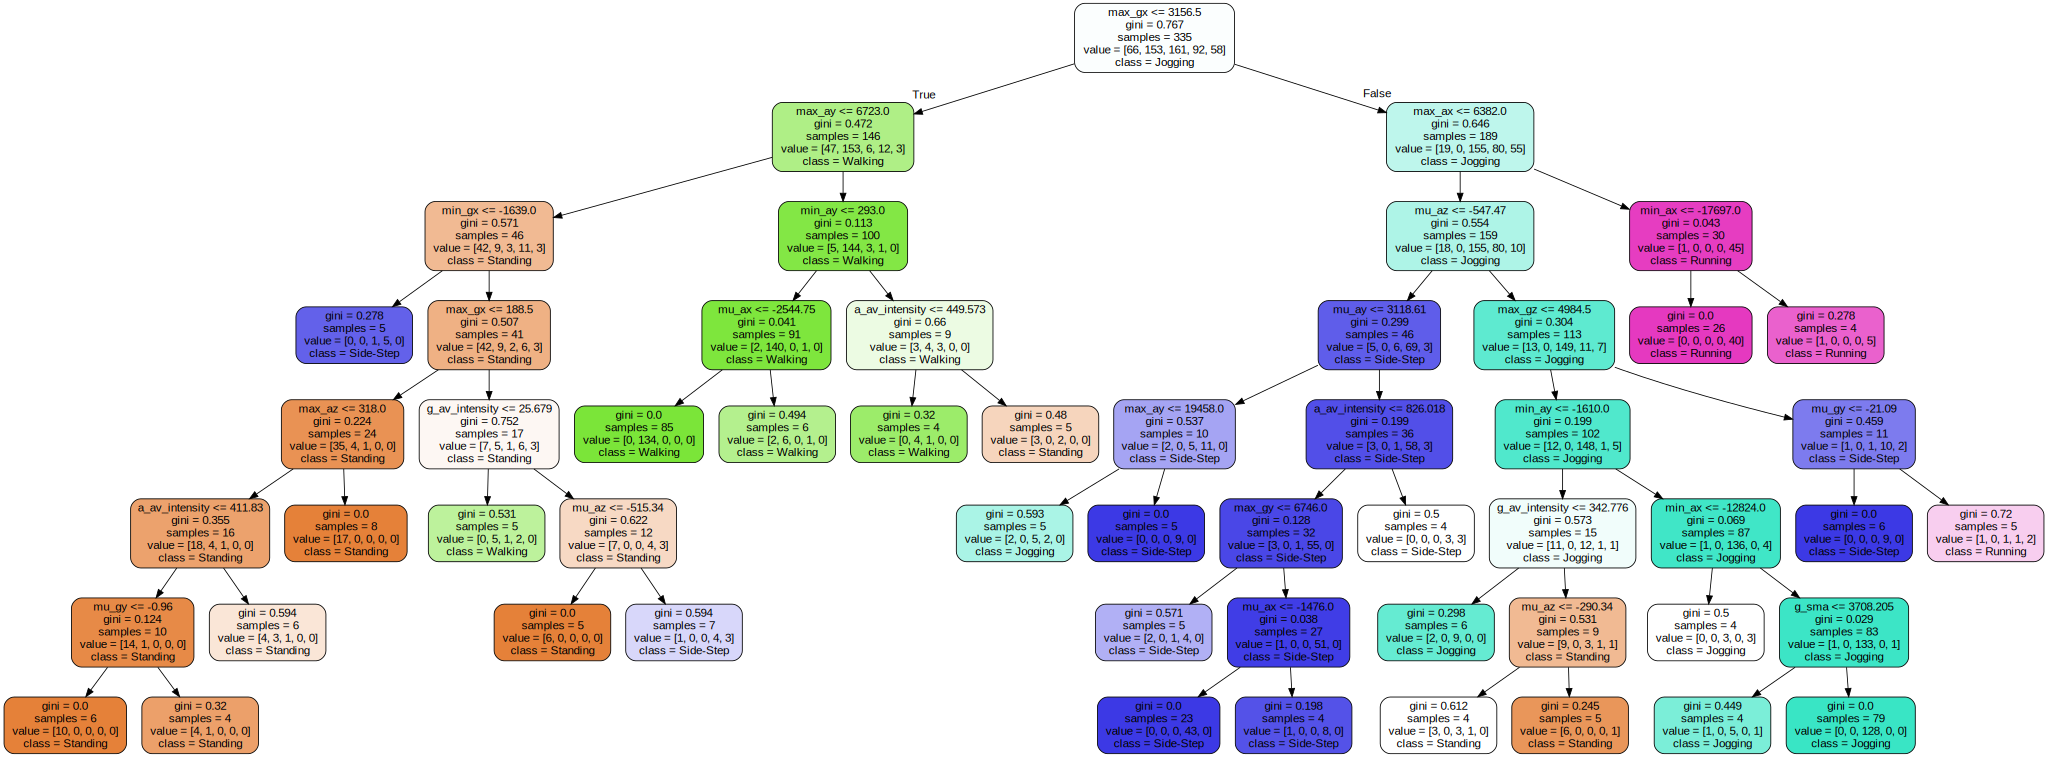

In [21]:
rfc = RandomForestClassifier(n_estimators=90, 
                            max_depth=12,
                            max_features='sqrt', 
                            min_samples_leaf=4,
                            bootstrap=True, 
                            n_jobs=-1, 
                            random_state=42)
rfc.fit(X_train, y_train)
# plotting the 90th Decision Tress
dot_data = export_graphviz(rfc.estimators_[89], 
                            feature_names=["mu_ax", "mu_ay", "mu_az", "mu_gx"," mu_gy"," mu_gz", \
                   "max_ax", "max_ay","max_az", "max_gx", "max_gy", "max_gz", \
                  " min_ax", "min_ay", "min_az", "min_gx", "min_gy", "min_gz", \
                   "a_sma", "g_sma", "a_av_intensity", "g_av_intensity"],
                           class_names=["Standing", "Walking","Jogging", "Side-Step", "Running"], 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='jpg')
graph

We can plot any tree from [0-90]. The above graphviz module is easy and simple to use and colorfull which made me use that module for the decision tree visualization.

### Conclusion

We implement the a machine learning workflow across a dataset for  Activity classification (ie. identifying waling , running, standing , and so on). we extract the features from the raw vedio datasets.After implementing multiple machine learning classification algorithm, we came to conclusion that Random forest classifier is good enough to handle that types of workflow. 

After analysing different algorithm, extracting multiple features from single frame of the vedio clip . We classify successfully (about 87% ) of accuracy on the IMU dataset for classifying the activity such as walking, running, etc.